<a href="https://colab.research.google.com/github/singhsukhendra/2015/blob/master/RESNET_WITH_ATTENTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import warnings
warnings.filterwarnings('ignore')
import cv2
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import keras
from keras.models import Sequential, Model,load_model
from tensorflow.keras.optimizers import SGD
from keras.callbacks import EarlyStopping,ModelCheckpoint
from google.colab.patches import cv2_imshow
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform
from tensorflow.keras import activations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau
import cv2
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
# ensure consistency across runs
from numpy.random import seed
seed(1)

# Imports to view data
import cv2
from glob import glob

#for alternative imports you can use 
#from keras.preprocessing.image import ImageDataGenerator
#from keras.models import Sequential
#from keras.layers import Conv2D, SeparableConv2D, Dense, Dropout, Flatten, LSTM,MaxPool2D, BatchNormalization
#from keras import backend
#from keras import Input
#from keras.models import Model
#from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping


from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, SeparableConv2D, Dense, Dropout, Flatten, LSTM,MaxPool2D, BatchNormalization
from tensorflow.keras import backend
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping


import numpy as np
import pandas as pd 
import os
# print(os.listdir("../input"))
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D,
                          BatchNormalization, Input, Conv2D, GlobalAveragePooling2D,concatenate,Concatenate,multiply, LocallyConnected2D, Lambda)
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import metrics
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
# import efficientnet.tfkeras as efn 
import skimage.io
from skimage.transform import resize
import imgaug as aug
from imgaug import augmenters as iaa
from tqdm import tqdm
import PIL
from PIL import Image, ImageOps
import cv2
from sklearn.utils import class_weight, shuffle
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy
#from keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.densenet import DenseNet121,DenseNet169,preprocess_input
import tensorflow.keras.backend as K
from sklearn.metrics import f1_score, fbeta_score, cohen_kappa_score
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import imgaug as ia
import tensorflow.keras.callbacks as callbacks
from tensorflow.keras.callbacks import Callback
get_ipython().run_line_magic('config', 'InlineBackend.figure_format="svg"')
get_ipython().run_line_magic('matplotlib', 'inline')

WORKERS = 2
CHANNEL = 3

import warnings
warnings.filterwarnings("ignore")

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

In [4]:
import os
initial_count = 0
dir = "/content/drive/MyDrive/data/PNEUMONIA"
for path in os.listdir(dir):
    if os.path.isfile(os.path.join(dir, path)):
        initial_count += 1
print(initial_count)

4273


In [5]:
import os
initial_count = 0
dir = "/content/drive/MyDrive/data/NORMAL"
for path in os.listdir(dir):
    if os.path.isfile(os.path.join(dir, path)):
        initial_count += 1
print(initial_count)




1583


In [6]:
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(str(e))
    return np.array(data)
  
data = get_training_data('/content/drive/MyDrive/data')
np.save('data.npy', data, allow_pickle=True)

In [7]:
# If you've already ran the previous code block, run this one instead.
data = np.load('data.npy', allow_pickle=True)

In [8]:
# Shuffle dataset
np.random.seed(1337)
np.random.shuffle(data)

In [9]:
train, val, test = np.split(data, [int(.75*len(data)), int(.80*len(data))])

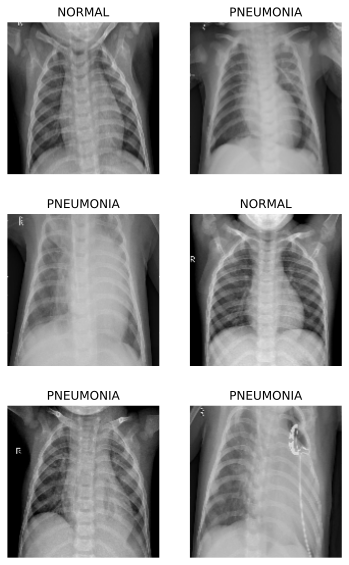

In [10]:
fig, ax = plt.subplots(3, 2, figsize=(6,10), facecolor='white')
for idx, item in enumerate(np.random.randint(0, train.shape[0], 6)):
    ax[int(idx/2)][idx%2].imshow(train[item][0], cmap='gray')
    ax[int(idx/2)][idx%2].set_title(labels[train[item][1]])
    ax[int(idx/2)][idx%2].axis('off')

In [11]:
print(data.shape)
print(train.shape, val.shape, test.shape)

(5856, 2)
(4392, 2) (292, 2) (1172, 2)


In [12]:
# Train set splits
unique, counts = np.unique(train[:, 1], return_counts=True)
print(np.asarray((unique, counts)).T)

[[0 3205]
 [1 1187]]


In [13]:
# Test set splits
unique, counts = np.unique(test[:, 1], return_counts=True)
print(np.asarray((unique, counts)).T)

[[0 842]
 [1 330]]


In [14]:
# Validation set splits
unique, counts = np.unique(val[:, 1], return_counts=True)
print(np.asarray((unique, counts)).T)

[[0 226]
 [1 66]]


In [15]:
unique, counts = np.unique(data[:, 1], return_counts=True)
print(np.asarray((unique, counts)).T)

[[0 4273]
 [1 1583]]


In [16]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

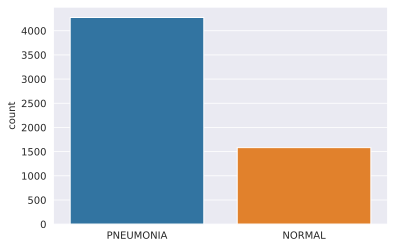

In [17]:
l = []
for i in data:
    if(i[1] == 0):
        l.append("PNEUMONIA")
    else:
        l.append("NORMAL")
sns.set_style('darkgrid')
sns.countplot(l)

In [18]:
# Normalize data. Pixels are [0, 255], so dividing will place them into a [0, 1] range.
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [19]:
# Resize all images into a common size of 150 x 150
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [20]:
print(x_train[0].shape, x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape)

(150, 150, 1) (4392, 150, 150, 1) (4392,) (292, 150, 150, 1) (292,) (1172, 150, 150, 1) (1172,)


In [21]:
# Data augmentation to prevent overfitting and handling the imbalance in dataset
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [22]:
class ChannelAttention(tf.keras.layers.Layer):
      def __init__(self, filters, ratio):
        super(ChannelAttention, self).__init__()
        self.filters = filters
        self.ratio = ratio

        def build(self, input_shape):
            self.shared_layer_one = tf.keras.layers.Dense(self.filters//self.ratio,
                             activation='relu', kernel_initializer='he_normal', 
                              use_bias=True, 
                              bias_initializer='zeros')
            self.shared_layer_two = tf.keras.layers.Dense(self.filters,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')

        def call(self, inputs):
            # AvgPool
            avg_pool = tf.keras.layers.GlobalAveragePooling2D()(inputs)
            

            avg_pool = self.shared_layer_one(avg_pool)
            avg_pool = self.shared_layer_two(avg_pool)

            # MaxPool
            max_pool = tf.keras.layers.GlobalMaxPooling2D()(inputs)
            max_pool = tf.keras.layers.Reshape((1,1,filters))(max_pool)

            max_pool = self.shared_layer_one(max_pool)
            max_pool = self.shared_layer_two(max_pool)


            attention = tf.keras.layers.Add()([avg_pool,max_pool])
            attention = tf.keras.layers.Activation('sigmoid')(attention)
            
            return tf.keras.layers.Multiply()([inputs, attention])

class SpatialAttention(tf.keras.layers.Layer):
      def __init__(self, kernel_size):
        super(SpatialAttention, self).__init__()
        self.kernel_size = kernel_size
        
        def build(self, input_shape):
            self.conv2d = tf.keras.layers.Conv2D(filters = 1,
                    kernel_size=self.kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)

        def call(self, inputs):
            
            # AvgPool
            avg_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=3, keepdims=True))(inputs)
            
            # MaxPool
            max_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.max(x, axis=3, keepdims=True))(inputs)

            attention = tf.keras.layers.Concatenate(axis=3)([avg_pool, max_pool])

            attention = self.conv2d(attention)


            return tf.keras.layers.multiply([inputs, attention])

def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X
   
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X

def convolutional_block(X, f, filters, stage, block, s=2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [23]:
def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X
   
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X


def convolutional_block(X, f, filters, stage, block, s=2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [24]:
# def create_model():
#   input_im = Input(shape=(150,150,1)) # cifar 10 images size
#   x = ZeroPadding2D(padding=(3, 3))(input_im)

#   # 1st stage
#   # here we perform maxpooling, see the figure above

#   x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2))(x)
#   x = BatchNormalization()(x)
#   x = Activation(activations.relu)(x)
#   # x = ChannelAttention(64, 8)(x)
#   # x = SpatialAttention(3)(x)
#   x = MaxPooling2D((3, 3), strides=(2, 2))(x)

#   #2nd stage 
#   # frm here on only conv block and identity block, no pooling

#   x = res_conv(x, s=1, filters=(64, 256))
#   x = res_identity(x, filters=(64, 256))
#   x = res_identity(x, filters=(64, 256))

#   # 3rd stage

#   x = res_conv(x, s=2, filters=(128, 512))
#   x = res_identity(x, filters=(128, 512))
#   x = res_identity(x, filters=(128, 512))
#   x = res_identity(x, filters=(128, 512))

#   # 4th stage

#   x = res_conv(x, s=2, filters=(256, 1024))
#   x = res_identity(x, filters=(256, 1024))
#   x = res_identity(x, filters=(256, 1024))
#   x = res_identity(x, filters=(256, 1024))
#   x = res_identity(x, filters=(256, 1024))
#   x = res_identity(x, filters=(256, 1024))

#   # 5th stage

#   x = res_conv(x, s=2, filters=(512, 2048))
#   x = res_identity(x, filters=(512, 2048))
#   x = res_identity(x, filters=(512, 2048))

#   # ends with average pooling and dense connection

#   x = AveragePooling2D((2, 2), padding='same')(x)

#   x = Flatten()(x)
#   x = Dense(1, activation='softmax', kernel_initializer='he_normal')(x) #multi-class

#   # define the model 

#   model = Model(inputs=input_im, outputs=x, name='Resnet50')

#   return model

In [25]:
def create_model(input_shape=(150, 150, 1)):

    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = ChannelAttention(64, 8)(X)
    X = SpatialAttention(3)(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = ChannelAttention(64, 8)(X)
    X = SpatialAttention(3)(X)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = ChannelAttention(128, 8)(X)
    X = SpatialAttention(3)(X)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = ChannelAttention(256, 8)(X)
    X = SpatialAttention(3)(X)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = ChannelAttention(512, 8)(X)
    X = SpatialAttention(3)(X)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

In [26]:
base_model = create_model(input_shape=(150, 150, 1))
headModel = base_model.output
headModel = Flatten()(headModel)
headModel=Dense(256, activation='relu', name='fc1',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel=Dense(128, activation='relu', name='fc2',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel = Dense( 1,activation='sigmoid', name='fc3',kernel_initializer=glorot_uniform(seed=0))(headModel)

In [27]:
model = Model(inputs=base_model.input, outputs=headModel)

In [28]:
n_epoch = 80
lr = 0.001
batchsz = 64


METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='roc', curve='ROC'), # roc curve
      tf.keras.metrics.AUC(name='prc', curve='PR') # precision-recall curve
]

In [29]:
optim = tf.keras.optimizers.Adam(lr=lr)
# model = create_model()
model.compile(optimizer = optim, loss = 'binary_crossentropy', metrics = METRICS)

learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy', patience=2, verbose=1, factor=0.8
)

history = model.fit(
    datagen.flow(x_train, y_train, batch_size=batchsz), 
    epochs = n_epoch, 
    validation_data = datagen.flow(x_val, y_val),
    callbacks = [learning_rate_reduction]
)

Epoch 1/80
69/69 [==============================] - 48s 420ms/step - loss: 1.0964 - tp: 476.0000 - fp: 453.0000 - tn: 2752.0000 - fn: 711.0000 - accuracy: 0.7350 - precision: 0.5124 - recall: 0.4010 - roc: 0.7064 - prc: 0.4451 - val_loss: 1.2396 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 226.0000 - val_fn: 66.0000 - val_accuracy: 0.7740 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc: 0.5000 - val_prc: 0.2260 - lr: 0.0010
Epoch 2/80
69/69 [==============================] - 25s 361ms/step - loss: 0.3607 - tp: 930.0000 - fp: 337.0000 - tn: 2868.0000 - fn: 257.0000 - accuracy: 0.8648 - precision: 0.7340 - recall: 0.7835 - roc: 0.9167 - prc: 0.7807 - val_loss: 1.8481 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 226.0000 - val_fn: 66.0000 - val_accuracy: 0.7740 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc: 0.5000 - val_prc: 0.2260 - lr: 0.0010
Epoch 3/80
69/69 [==============================] - ETA: 0s - loss: 0.2528 - tp: 971.0000 - fp: 209.

In [30]:
results = model.evaluate(x_test,y_test)

37/37 [==============================] - 5s 78ms/step - loss: 0.1506 - tp: 323.0000 - fp: 43.0000 - tn: 799.0000 - fn: 7.0000 - accuracy: 0.9573 - precision: 0.8825 - recall: 0.9788 - roc: 0.9886 - prc: 0.9683


In [31]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 156, 156, 1)  0          ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 75, 75, 64)   3200        ['zero_padding2d[0][0]']         
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1[0][0]']              

In [32]:
print("Loss of the model is - " , results[0])
print("True positives of the model is - " , results[1])
print("False positives of the model is - " , results[2])
print("True negatives of the model is - " , results[3])
print("False negatives of the model is - " , results[4])
print("Accuracy of the model is - " , results[5]*100 , "%")
print("Precision of the model is - " , results[6])
print("Recall of the model is - " , results[7])
print("ROC_AUC of the model is - " , results[8])
print("PRC_AUC of the model is - " , results[9])

Loss of the model is -  0.15063679218292236
True positives of the model is -  323.0
False positives of the model is -  43.0
True negatives of the model is -  799.0
False negatives of the model is -  7.0
Accuracy of the model is -  95.73378562927246 %
Precision of the model is -  0.8825136423110962
Recall of the model is -  0.978787899017334
ROC_AUC of the model is -  0.988585889339447
PRC_AUC of the model is -  0.9683214426040649


In [33]:
def plot_metrics(history):
    
    fig = plt.gcf()
    fig.set_size_inches(20, 3 * 4)

    metrics = ['roc','accuracy','loss', 'prc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        lims = {'loss': {0,2}}
        name = metric.replace("_"," ").capitalize()
        sp = plt.subplot(2, 3, n + 1)
        plt.plot(history.epoch, history.history[metric], color='C0', label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color='C1', linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric in lims:
            plt.ylim(lims[metric])

        plt.legend()

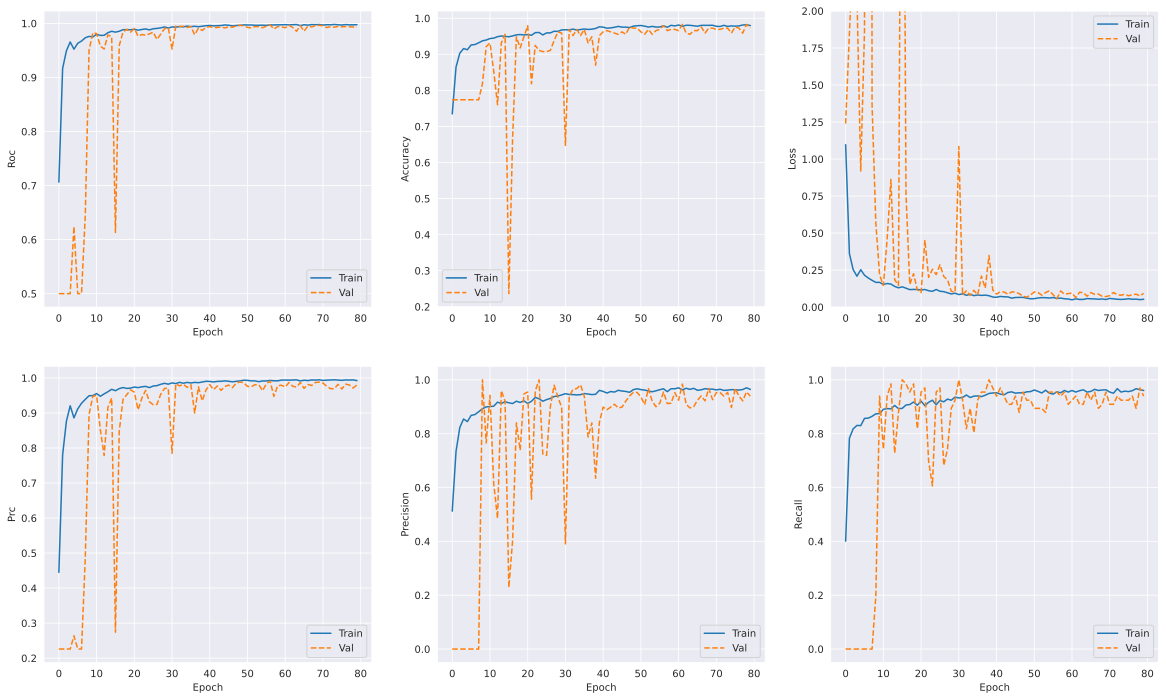

In [34]:
plot_metrics(history)

In [35]:
predictions = (model.predict(x_test) > 0.5).astype("int32")
predictions = predictions.reshape(1,-1)[0]
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.99      0.95      0.97       842
   Normal (Class 1)       0.88      0.98      0.93       330

           accuracy                           0.96      1172
          macro avg       0.94      0.96      0.95      1172
       weighted avg       0.96      0.96      0.96      1172



In [36]:
from sklearn.metrics import f1_score
f1_score(y_test, predictions)

0.9281609195402298

Text(69.0, 0.5, 'true label')

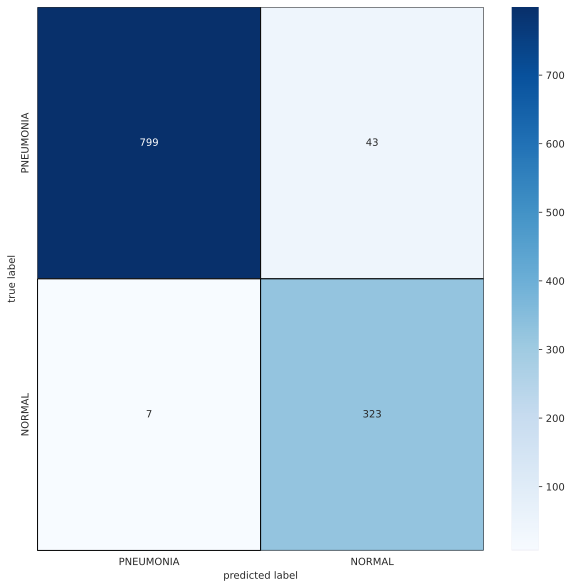

In [37]:
cm = confusion_matrix(y_test,predictions)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (10,10))
sns.heatmap(cm, cmap= "Blues", linecolor = 'black' , 
            linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)
plt.xlabel('predicted label')
plt.ylabel('true label')

In [38]:
model.save('/content/mymodel')

INFO:tensorflow:Assets written to: /content/mymodel/assets


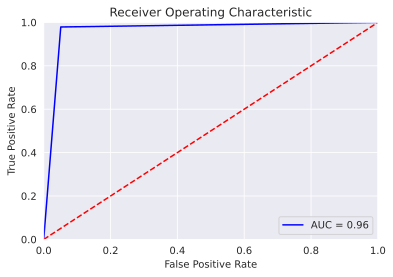

In [39]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = (model.predict(x_test) )
probs=predictions = (model.predict(x_test) > 0.5).astype("int32")
#predictions = predictions.reshape(1,-1)[0]
preds = probs[:,]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()